In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [35]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [12]:
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [14]:
train = pd.read_csv("C:/Users/se675014/Desktop/COMP 541/predict-student-performance-from-game-play/train.csv")
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [15]:
train = reduce_memory_usage(train)
train.info()

Memory usage of dataframe is 4012.60 MB
Memory usage became:  1028.2593364715576  MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int8    
 17  hq              int8    
 18  music           int8    
 19  level_group     category
dtypes: category(7), float16(5), float32(1), int16(1), int32(1), int64(1), int8(4)
memory usage: 1.0 GB


In [16]:
train.shape

(26296946, 20)

In [17]:
import gc
gc.collect()

0

In [18]:
target = pd.read_csv("C:/Users/se675014/Desktop/COMP 541/predict-student-performance-from-game-play/train_labels.csv")
target.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [19]:
target['session'] = target.session_id.apply(lambda x: int(x.split('_')[0]) )
target['q'] = target.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( target.shape )
target.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [20]:
gc.collect()

0

In [21]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [22]:
summary_table = summary(train)
summary_table

data shape: (26296946, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
session_id,int64,0,0.000000,23562,20090312431273200.0,22100221145014656.0,20090312431273200,20090312431273200,20090312431273200
index,int16,0,0.000000,20348,0.0,20473.0,0,1,2
elapsed_time,int32,0,0.000000,5042639,0.0,1988606704.0,0,1323,831
event_name,category,0,0.000000,11,NaN,NaN,cutscene_click,person_click,person_click
name,category,0,0.000000,6,NaN,NaN,basic,basic,basic
level,int8,0,0.000000,23,0.0,22.0,0,0,0
page,float16,2573240200,0.978532,7,0.0,6.0,NaN,NaN,NaN
room_coor_x,float16,207327200,0.078841,29854,-1992.0,1262.0,-414.0,-414.0,-414.0
room_coor_y,float16,207327200,0.078841,27847,-918.0,543.5,-159.375,-159.375,-159.375
screen_coor_x,float16,207327200,0.078841,6866,0.0,1919.0,380.0,380.0,380.0


In [23]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y','screen_coor_x', 'screen_coor_y', 'hover_duration']

In [24]:
just_dummies = pd.get_dummies(train['event_name'])

train = pd.concat([train, just_dummies], axis=1)

In [25]:
train['event_name'].value_counts()

event_name
navigate_click        11326433
person_click           6052853
cutscene_click         2703035
object_click           2198211
object_hover           1057085
map_hover               945159
notification_click      649001
notebook_click          564544
map_click               517242
observation_click       212355
checkpoint               71028
Name: count, dtype: int64

In [26]:
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [27]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [28]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(70686, 31)
CPU times: total: 1min 2s
Wall time: 1min 2s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.688968,-71.412109,...,81,22,28,11,4,8,2,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.360092,-162.006699,...,170,123,60,20,14,10,6,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306852,-57.270126,...,103,104,12,28,9,9,8,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.042580,-53.671711,...,49,18,36,15,3,5,3,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.756248,-142.858322,...,637,145,65,83,186,14,45,5,1,3241011333


In [29]:
gc.collect()

0

In [30]:
df.dtypes

level_group               category
event_name_nunique           int64
fqid_nunique                 int64
room_fqid_nunique            int64
text_nunique                 int64
elapsed_time_mean          float64
level_mean                 float64
page_mean                  float32
room_coor_x_mean           float32
room_coor_y_mean           float32
screen_coor_x_mean         float32
screen_coor_y_mean         float32
hover_duration_mean        float32
elapsed_time_std           float64
level_std                  float64
page_std                   float64
room_coor_x_std            float64
room_coor_y_std            float64
screen_coor_x_std          float64
screen_coor_y_std          float64
hover_duration_std         float64
navigate_click_sum           int64
person_click_sum             int64
cutscene_click_sum           int64
object_click_sum             int64
map_hover_sum                int64
notification_click_sum        int8
map_click_sum                int64
observation_click_su

In [31]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 30 features
We will train with 23562 users info


In [36]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
models = {}

for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#' * 25)
    print('### Fold', i + 1)
    print('#' * 25)

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.05,
        'max_depth': 4,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'tree_method': 'hist',
        'subsample': 0.8,
        'colsample_bytree': 0.4,
        'use_label_encoder': False}

    for t in range(1, 19):
        if t <= 3:
            grp = '0-4'
        elif t <= 13:
            grp = '5-12'
        elif t <= 22:
            grp = '13-22'

        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = target.loc[target.q == t].set_index('session').loc[train_users]

        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = target.loc[target.q == t].set_index('session').loc[valid_users]

        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)

        # No clf.best_ntree_limit, use early_stopping_rounds to automatically determine the best number of trees
        best_ntree_limit = clf.best_iteration
        print(f'{t}({best_ntree_limit}), ', end='')

        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t - 1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:, 1]

    print()

#########################
### Fold 1
#########################
1(156), 2(92), 3(103), 4(191), 5(102), 6(95), 7(72), 8(72), 9(173), 10(245), 11(83), 12(91), 13(138), 14(279), 15(197), 16(70), 17(70), 18(105), 
#########################
### Fold 2
#########################
1(138), 2(167), 3(88), 4(157), 5(93), 6(147), 7(104), 8(85), 9(158), 10(114), 11(183), 12(78), 13(85), 14(197), 15(186), 16(89), 17(71), 18(105), 
#########################
### Fold 3
#########################
1(208), 2(100), 3(89), 4(238), 5(116), 6(116), 7(117), 8(51), 9(126), 10(131), 11(76), 12(51), 13(100), 14(185), 15(216), 16(66), 17(143), 18(110), 
#########################
### Fold 4
#########################
1(149), 2(127), 3(68), 4(245), 5(249), 6(201), 7(81), 8(56), 9(128), 10(108), 11(107), 12(82), 13(170), 14(193), 15(202), 16(60), 17(27), 18(81), 
#########################
### Fold 5
#########################
1(165), 2(103), 3(127), 4(237), 5(162), 6(118), 7(109), 8(58), 9(95), 10(140), 11(74), 12(74), 1

In [37]:
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = target.loc[target.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [38]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

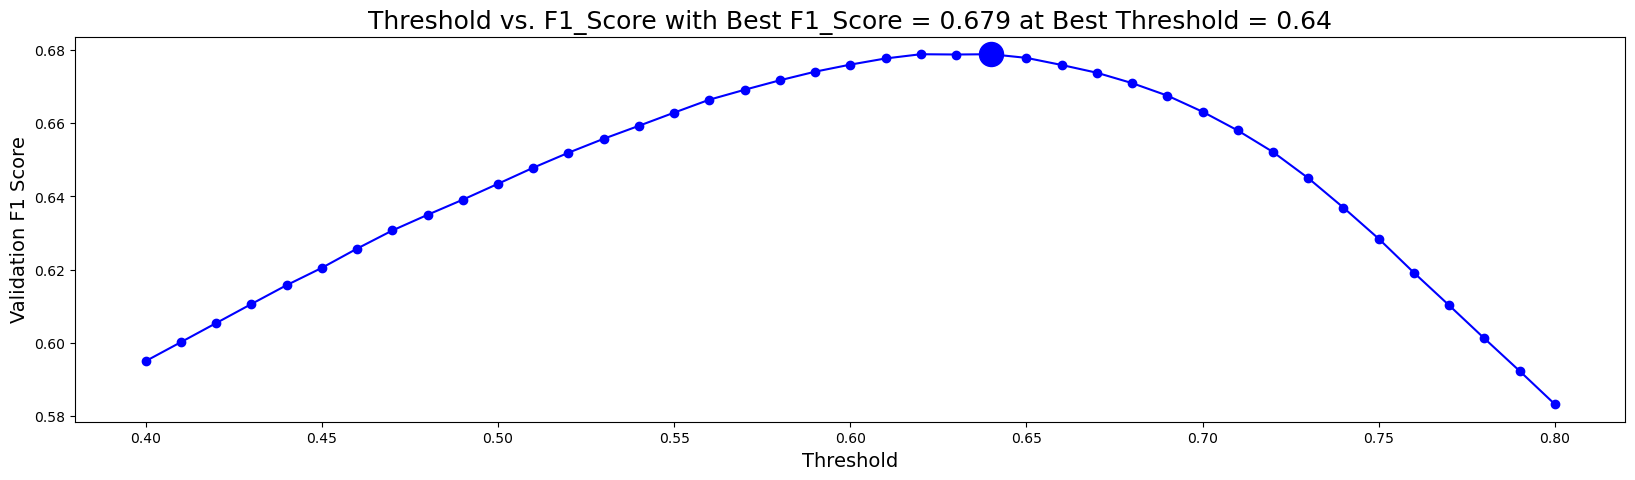

In [39]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [40]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6095381904926087
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.48783487044356605
Q3: F1 = 0.6257099330609948
Q4: F1 = 0.5660123776726447
Q5: F1 = 0.6124651293218755
Q6: F1 = 0.5887478714611551
Q7: F1 = 0.5251241284042005
Q8: F1 = 0.6056675007653045
Q9: F1 = 0.5053055501604755
Q10: F1 = 0.5882806888294334
Q11: F1 = 0.49366430864239874
Q12: F1 = 0.4330160480863937
Q13: F1 = 0.6104605954808657
Q14: F1 = 0.49921752377456974
Q15: F1 = 0.4728756416003716
Q16: F1 = 0.5460981908575167
Q17: F1 = 0.4881344531968328
==> Overall F1 = 0.6788423375092605
